This notebook goes through Allen datasets and pulls out specific cell types or subtypes.

In [12]:
import loompy as lp
import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import matplotlib.pyplot as plt
import time
import os.path


In [13]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/cluster.membership.csv',\
                               skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/cluster.annotation.csv')


In [14]:
allen_membership

,barcode,cluster_id
0,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,42
1,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,41
2,AAACCCACACCAGCCA-1L8TX_181211_01_G12,42
3,AAACCCAGTGAACGGT-1L8TX_181211_01_G12,41
4,AAACCCAGTGGCATCC-1L8TX_181211_01_G12,20
...,...,...
94165,TTTGTTGTCAGCATTG-12L8TX_190430_01_G08,40
94166,TTTGTTGTCATTGCGA-12L8TX_190430_01_G08,41
94167,TTTGTTGTCCCAACTC-12L8TX_190430_01_G08,43
94168,TTTGTTGTCTATGCCC-12L8TX_190430_01_G08,42


In [15]:
allen_annot

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
0,1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,81
1,2,Lamp5 Egln3_2_1,Lamp5,GABAergic,#DD8091,179
2,3,Lamp5 Pdlim5_1,Lamp5,GABAergic,#FF829E,247
3,4,Lamp5 Pdlim5_2,Lamp5,GABAergic,#FF7290,537
4,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275
...,...,...,...,...,...,...
142,143,L6b Shisa6_low_1,Low Quality,Low Quality,#5A7A65,84
143,144,L6b Shisa6_low_2,Low Quality,Low Quality,#1F7C70,95
144,145,Oligo Opalin_neuon,doublet,Low Quality,#41775C,16
145,146,Endo Slc38a5_5,doublet,Low Quality,#4C6863,36


In [41]:
annot_bcs = list(allen_membership['barcode'])
annot_cid = np.asarray(allen_membership['cluster_id'])
annot_exp = np.asarray([x[-3:] for x in annot_bcs])
annot_bcs = np.asarray([x[:16] for x in annot_bcs])
annot_n = len(annot_bcs)

Shift cluster ID down by one because the annotation is one-indexed.

In [42]:
annot_cid -= 1

In [83]:
celltype_names = ['GABAergic','Glutamatergic',
                  'Lamp5','Sncg','Vip','Sst','Pvalb',
                  'L2/3 IT', 'L5 IT', 'L6 IT', 'L6 IT Car3', 'L5 ET', 'L5/6 NP', 'L6 CT', 'L6b']
celltype_abbr = ['gaba','glu',
                 'lamp5','scng','vip','sst','pvalb',
                 'l23it','l5it','l6it','l6itcar3','l5et', 'l56np', 'l6ct', 'l6b']
n_celltypes = len(celltype_names)

In [84]:
celltype_clusters = [np.where(allen_annot['class_label'] == x)[0] for x in celltype_names[:2]] + \
                    [np.where(allen_annot['subclass_label'] == x)[0] for x in celltype_names[2:]]

Remove Sncg and L6 IT Car3 clusters from further analysis.

In [85]:
celltype_clusters[0] = np.asarray([x for x in celltype_clusters[0] if not x in celltype_clusters[3]])
celltype_clusters[1] = np.asarray([x for x in celltype_clusters[1] if not x in celltype_clusters[10]])

In [86]:
celltype_clusters

[array([ 0,  1,  2,  3,  4,  5,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38]),
 array([39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([0, 1, 2, 3, 4, 5]),
 array([6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]),
 array([35, 36, 37, 38]),
 array([39]),
 array([40, 41, 42, 43]),
 array([44, 45, 46, 47]),
 array([48]),
 array([49, 50, 51]),
 array([52, 53, 54, 55, 56, 57]),
 array([58, 59, 60, 61, 62, 63]),
 array([64, 65, 66, 67])]

In [87]:
celltype_names

['GABAergic',
 'Glutamatergic',
 'Lamp5',
 'Sncg',
 'Vip',
 'Sst',
 'Pvalb',
 'L2/3 IT',
 'L5 IT',
 'L6 IT',
 'L6 IT Car3',
 'L5 ET',
 'L5/6 NP',
 'L6 CT',
 'L6b']

In [89]:
annot_cid_filter = np.zeros((n_celltypes,len(annot_bcs)),dtype=bool)
for cl in range(n_celltypes):
    annot_cid_filter[cl,:] = np.isin(annot_cid,celltype_clusters[cl])

In [90]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'


In [91]:
def knee_plot(S,n_cells,ax1,thr=None,viz=False):
    umi_sum = S.sum(0)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells),usf,'k')
        ax1.set_xlabel('Cell rank')
        ax1.set_ylabel('UMI count+1')
        ax1.set_yscale('log')
    if thr is not None:
        cf = umi_sum>thr
        rank_ = np.argmin(np.abs(usf-thr))
        if viz:
            ax1.plot([0,n_cells+1],thr*np.ones(2),'r--')
            ys = ax1.get_ylim()
            ax1.plot(rank_*np.ones(2),ys,'r--')
        return cf

/home/ggorin/count_data/allen_B08/counts_filtered/adata.loom
allen_B08: 10975 barcodes before knee plot filtering.
allen_B08: 7584 barcodes after knee plot filtering.
allen_B08_gaba: 1551 barcodes after selection.
allen_B08_glu: 4394 barcodes after selection.
allen_B08_lamp5: 191 barcodes after selection.
allen_B08_scng: 29 barcodes after selection.
allen_B08_vip: 169 barcodes after selection.
allen_B08_sst: 262 barcodes after selection.
allen_B08_pvalb: 933 barcodes after selection.
allen_B08_l23it: 621 barcodes after selection.
allen_B08_l5it: 1702 barcodes after selection.
allen_B08_l6it: 471 barcodes after selection.
allen_B08_l6itcar3: 1 barcodes after selection.
allen_B08_l5et: 57 barcodes after selection.
allen_B08_l56np: 191 barcodes after selection.
allen_B08_l6ct: 1359 barcodes after selection.
allen_B08_l6b: 34 barcodes after selection.
/home/ggorin/count_data/allen_C01/counts_filtered/adata.loom
allen_C01: 12363 barcodes before knee plot filtering.
allen_C01: 8655 barcodes 

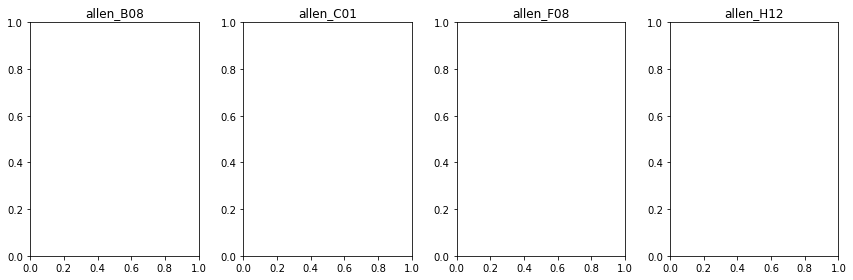

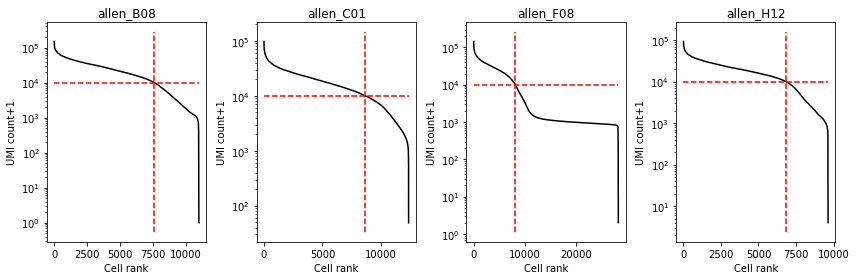

In [103]:
datasets = ['B08','C01','F08','H12']
# datasets = ['A08','B01','B08','C01','A01','D01','E01','F01','G12','H12','F08','G08']


thr = [1e4]*4
sz=(1,4)
fig2,ax2 = plt.subplots(sz[0],sz[1],figsize=(12,4))

outdir = '/home/ggorin/count_data/loom_allen_celltype_kb/test/'
for j in range(len(datasets)):
    d = datasets[j]
    axloc=j
#     axloc=np.unravel_index(j,sz)
    filename = '/home/ggorin/count_data/allen_{}/counts_filtered/adata.loom'.format(d)
    print(filename)
    while (os.path.isdir('/home/ggorin/count_data/allen_{}/tmp/'.format(d))):
        print('DNE...' ,end='\t')
        time.sleep(900)
        #clever async processing
    
    with lp.connect(filename) as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        
        print('allen_{}: {:.0f} barcodes before knee plot filtering.'.format(d,n_cells))



        knee_plot(S,n_cells,ax1=ax2[axloc],viz=True,thr=thr[j])
        ax2[axloc].set_title('allen_'+d)
        
        cf = S.sum(0)>thr[j]

        S = S[:,cf]
        U = U[:,cf]
        bcs = bcs[cf]
        n_cells = cf.sum()
        print('allen_{}: {:.0f} barcodes after knee plot filtering.'.format(d,cf.sum()))

        
        for celltype in range(n_celltypes):
            S_ = np.copy(S)
            U_ = np.copy(U)
            celltype_exp_bcs = annot_bcs[annot_cid_filter[celltype]]
            cf = np.asarray([True if (x in celltype_exp_bcs) else False for x in bcs])
            S_ = S[:,cf]
            U_ = U[:,cf]            
            bc_filt = bcs[cf]
            
            print('allen_{}_{}: {:.0f} barcodes after selection.'.format(d,celltype_abbr[celltype],cf.sum()))
            
            
            if S_.size>0:
                lp.create(outdir+'/allen_{}_{}.loom'.format(d,celltype_abbr[celltype]),\
                          layers={'':scipy.sparse.csr_matrix(S_.shape),
                                  spliced_layer:S_,
                                  unspliced_layer:U_},\
                                  row_attrs={gene_attr:gene_names},\
                                  col_attrs={cell_attr:bc_filt})

fig2.tight_layout()
fig_string = fig_dir + 'kneeplots_all.png'
plt.savefig(fig_string,dpi=450)

